t: 1.6414270171311505
water.max(): 50.9265799926409


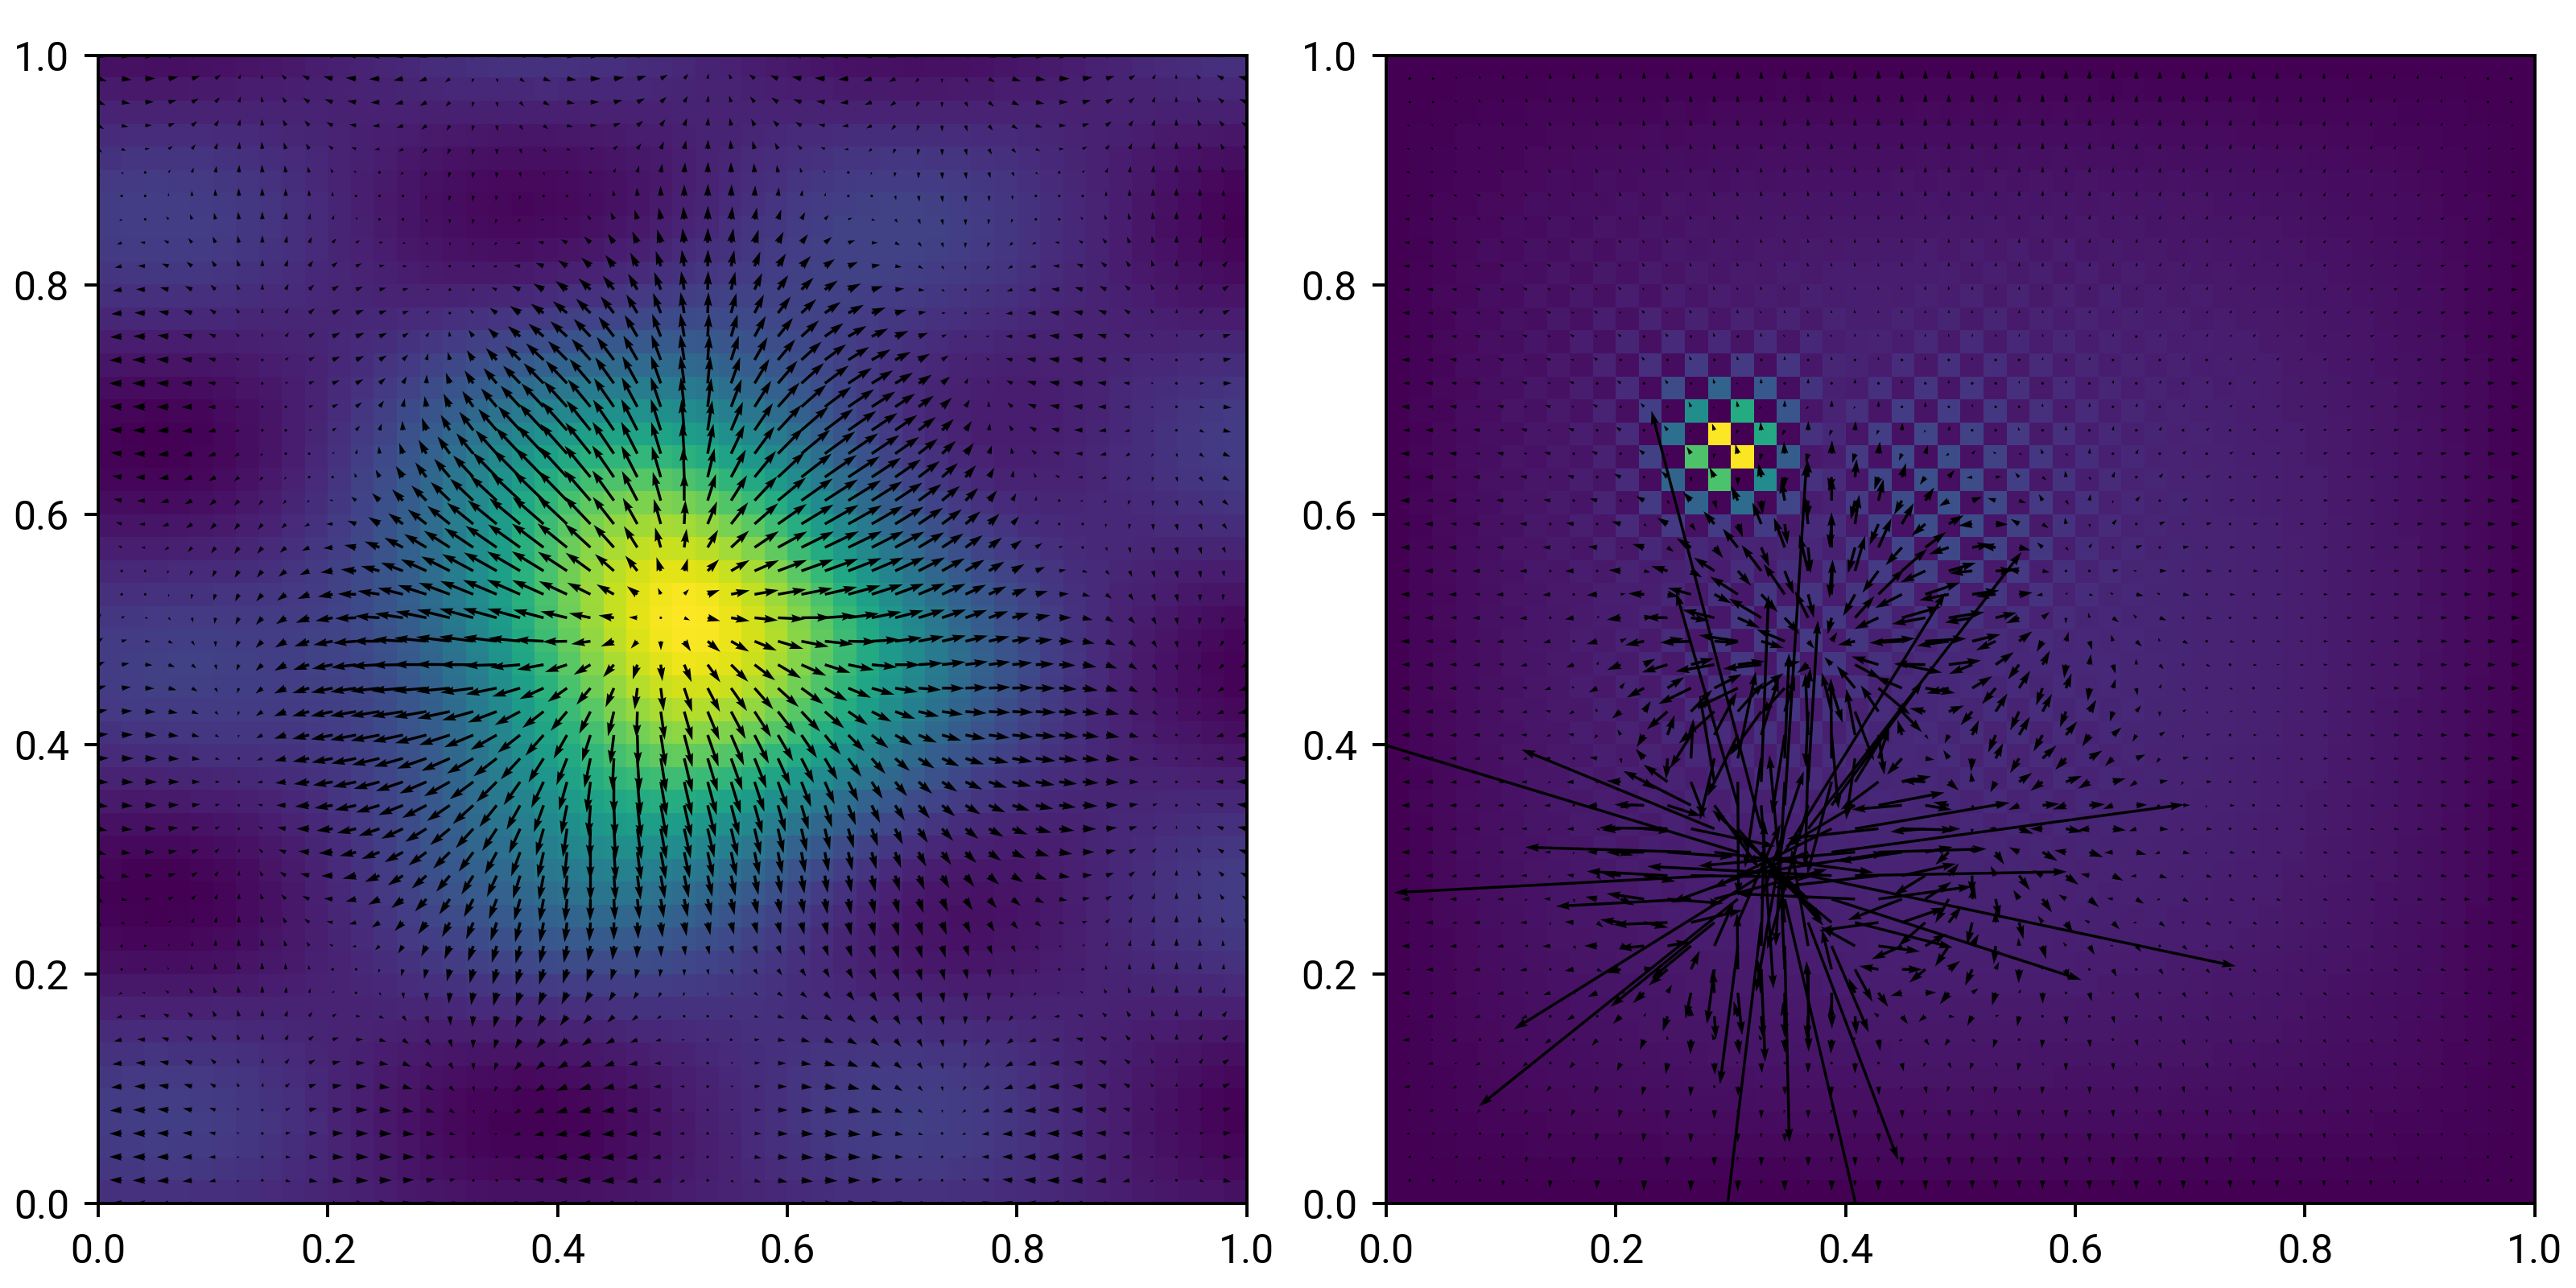

In [31]:
from joshpyutil import mpl
import numpy as np
import scipy.interpolate


n, m = 50, 50
terrain_r = 0.2
terrain_h = 0.1
alpha = 0.1
R = 0.01

x, delta_x = np.linspace(0, 1, n, retstep=True)
y, delta_y = np.linspace(0, 1, m, retstep=True)

X = x[:, np.newaxis]
Y = y[np.newaxis, :]
xx, yy = np.meshgrid(x, y, indexing='ij')


def grad(field):
    spline = scipy.interpolate.RectBivariateSpline(x, y, field)
    return np.stack([spline(x, y, dx=1), spline(x, y, dy=1)], axis=-1)


terrain = (
    terrain_h * np.exp(-((X - 1/2)**2 + (Y - 1/2)**2) / terrain_r**2)
    + 0.1 * terrain_h * np.sin(5 * np.pi * (X - 1/2) + 1) * np.cos(3 * np.pi * (Y - 1/2) - 2)
)
terrain_grad = grad(terrain)
water = np.zeros_like(terrain)

t = 0
for i in range(10000):
    water_interp = scipy.interpolate.RectBivariateSpline(x, y, water)
    vel = -alpha * (grad(water) + terrain_grad)
    dt = 0.5 * np.sqrt(delta_x**2 + delta_y**2) / np.sqrt(2) / np.linalg.norm(vel, axis=2).max()
    t += dt
    flux = water_interp(x, y)[:, :, np.newaxis] * vel
    
    # Lax method.
    water_inner = water[1:-1, 1:-1]
    water_inner[:] = 1/4 * (water[:-2, 1:-1] + water[2:, 1:-1] + water[1:-1, :-2] + water[1:-1, 2:])
    water_inner[:] -= dt/2 * (
        1/delta_x * (flux[2:, 1:-1, 0] - flux[:-2, 1:-1, 0])
        + 1/delta_y * (flux[1:-1, 2:, 1] - flux[1:-1, :-2, 1])
    )
    water_inner += R

print('t:', t)
print('water.max():', water.max())

with mpl.autoplot(1, 2, size_inches=(8, 4)) as ap:
    _ = ap.ax.imshow(terrain, extent=[x[0], x[-1], y[0], y[-1]])
    _ = ap.ax.quiver(xx, yy, -terrain_grad[:, :, 0], -terrain_grad[:, :, 1])
    ap.set(aspect=1)
    ap.ax.grid(False)
    
    ap = ap.next()
    _ = ap.ax.imshow(water, extent=[x[0], x[-1], y[0], y[-1]])
    _ = ap.ax.quiver(xx, yy, vel[:, :, 0], vel[:, :, 1])
    ap.set(aspect=1)
    ap.ax.grid(False)